In [13]:
import os
import pandas as pd
from pathlib import Path

base_path = '/kaggle/input'

print("=== DIABETES DATASETS ===\n")

diabetes_csv = f"{base_path}/pima-indians-diabetes-database/diabetes.csv"
if os.path.exists(diabetes_csv):
    df = pd.read_csv(diabetes_csv)
    print(f"Pima Diabetes CSV: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Target distribution:\n{df['Outcome'].value_counts()}\n")

retinal_base = f"{base_path}/diabetic-retinopathy-224x224-2019-data"
colored_images = f"{retinal_base}/colored_images"
train_csv = f"{retinal_base}/train.csv"

if os.path.exists(colored_images):
    folders = sorted([f for f in os.listdir(colored_images) if os.path.isdir(os.path.join(colored_images, f))])
    print(f"Retinal Image Folders: {folders}")
    for folder in folders:
        count = len(os.listdir(os.path.join(colored_images, folder)))
        print(f"  {folder}: {count} images")

if os.path.exists(train_csv):
    df_train = pd.read_csv(train_csv)
    print(f"\nRetinal Labels CSV: {df_train.shape}")
    print(f"Columns: {list(df_train.columns)}")
    if 'diagnosis' in df_train.columns:
        print(f"Class distribution:\n{df_train['diagnosis'].value_counts()}\n")

print("\n=== HEART DISEASE DATASETS ===\n")

heart_csv = f"{base_path}/heart-disease-dataset/heart.csv"
if os.path.exists(heart_csv):
    df_heart = pd.read_csv(heart_csv)
    print(f"Heart Disease CSV: {df_heart.shape}")
    print(f"Columns: {list(df_heart.columns)}")
    print(f"Target distribution:\n{df_heart['target'].value_counts()}\n")

ecg_base = f"{base_path}/ecg-analysis/ecg_data_new_version/ecg data new version"
if os.path.exists(ecg_base):
    ecg_folders = sorted([f for f in os.listdir(ecg_base) if os.path.isdir(os.path.join(ecg_base, f))])
    print(f"ECG Image Folders: {ecg_folders}")
    for folder in ecg_folders:
        folder_path = os.path.join(ecg_base, folder)
        count = len([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {folder}: {count} images")

=== DIABETES DATASETS ===

Pima Diabetes CSV: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Target distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Retinal Image Folders: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
  Mild: 370 images
  Moderate: 999 images
  No_DR: 1805 images
  Proliferate_DR: 295 images
  Severe: 193 images

Retinal Labels CSV: (3662, 2)
Columns: ['id_code', 'diagnosis']
Class distribution:
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


=== HEART DISEASE DATASETS ===

Heart Disease CSV: (1025, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Target distribution:
target
1    526
0    499
Name: count, dtype: int64

ECG Image Folders: ['abnormal_heartbeat_ecg_images', 'myocardial_infarction_ecg_images', 'normal_ecg_im

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pickle
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

DIABETES_CSV = '/kaggle/input/pima-indians-diabetes-database/diabetes.csv'
HEART_CSV = '/kaggle/input/heart-disease-dataset/heart.csv'
RETINAL_BASE = '/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images'
ECG_BASE = '/kaggle/input/ecg-analysis/ecg_data_new_version/ecg data new version'
RETINAL_LABELS = '/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv'

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("\nPaths and seeds configured successfully")

Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA available: True

Paths and seeds configured successfully


In [16]:
df_diabetes = pd.read_csv(DIABETES_CSV)

print("Diabetes CSV Dataset")
print(f"Shape: {df_diabetes.shape}")
print(f"\nFirst few rows:\n{df_diabetes.head()}")
print(f"\nData Info:")
print(df_diabetes.info())
print(f"\nMissing values:\n{df_diabetes.isnull().sum()}")
print(f"\nStatistical Summary:\n{df_diabetes.describe()}")

X_diabetes = df_diabetes.drop('Outcome', axis=1)
y_diabetes = df_diabetes['Outcome']

scaler_diabetes = StandardScaler()
X_diabetes_scaled = scaler_diabetes.fit_transform(X_diabetes)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
    X_diabetes_scaled, y_diabetes, test_size=0.2, random_state=SEED, stratify=y_diabetes
)

print(f"\nTrain set: {X_train_diabetes.shape}, Test set: {X_test_diabetes.shape}")
print(f"Train distribution:\n{pd.Series(y_train_diabetes).value_counts()}")
print(f"Test distribution:\n{pd.Series(y_test_diabetes).value_counts()}")

Diabetes CSV Dataset
Shape: (768, 9)

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies       

Diabetes XGBoost Accuracy: 0.7792

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       100
           1       0.70      0.65      0.67        54

    accuracy                           0.78       154
   macro avg       0.76      0.75      0.75       154
weighted avg       0.78      0.78      0.78       154


Confusion Matrix:
[[85 15]
 [19 35]]


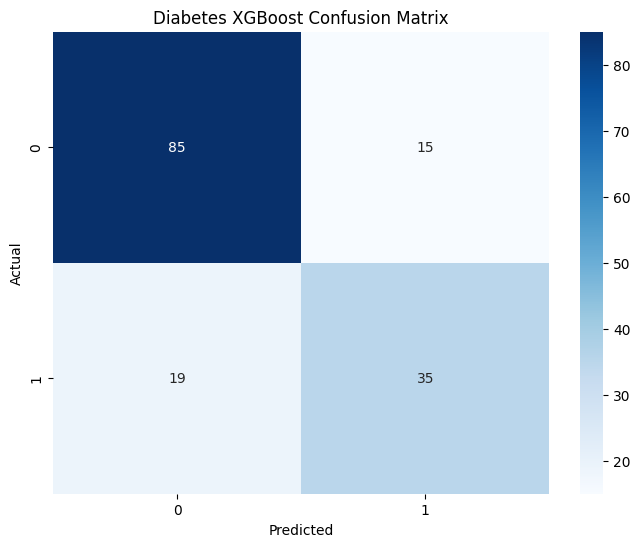


Diabetes XGBoost model and scaler saved


In [17]:
xgb_diabetes = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=SEED,
    eval_metric='logloss'
)

xgb_diabetes.fit(X_train_diabetes, y_train_diabetes)

y_pred_diabetes = xgb_diabetes.predict(X_test_diabetes)
y_pred_proba_diabetes = xgb_diabetes.predict_proba(X_test_diabetes)

accuracy = accuracy_score(y_test_diabetes, y_pred_diabetes)
print(f"Diabetes XGBoost Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_diabetes, y_pred_diabetes)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test_diabetes, y_pred_diabetes)}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_diabetes, y_pred_diabetes), annot=True, fmt='d', cmap='Blues')
plt.title('Diabetes XGBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

with open('diabetes_xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_diabetes, f)
with open('diabetes_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_diabetes, f)

print("\nDiabetes XGBoost model and scaler saved")

In [18]:
df_heart = pd.read_csv(HEART_CSV)

print("Heart Disease CSV Dataset")
print(f"Shape: {df_heart.shape}")
print(f"\nFirst few rows:\n{df_heart.head()}")
print(f"\nData Info:")
print(df_heart.info())
print(f"\nMissing values:\n{df_heart.isnull().sum()}")
print(f"\nStatistical Summary:\n{df_heart.describe()}")

X_heart = df_heart.drop('target', axis=1)
y_heart = df_heart['target']

scaler_heart = StandardScaler()
X_heart_scaled = scaler_heart.fit_transform(X_heart)

X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_heart_scaled, y_heart, test_size=0.2, random_state=SEED, stratify=y_heart
)

print(f"\nTrain set: {X_train_heart.shape}, Test set: {X_test_heart.shape}")
print(f"Train distribution:\n{pd.Series(y_train_heart).value_counts()}")
print(f"Test distribution:\n{pd.Series(y_test_heart).value_counts()}")

Heart Disease CSV Dataset
Shape: (1025, 14)

First few rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   t

Heart Disease XGBoost Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205


Confusion Matrix:
[[100   0]
 [  0 105]]


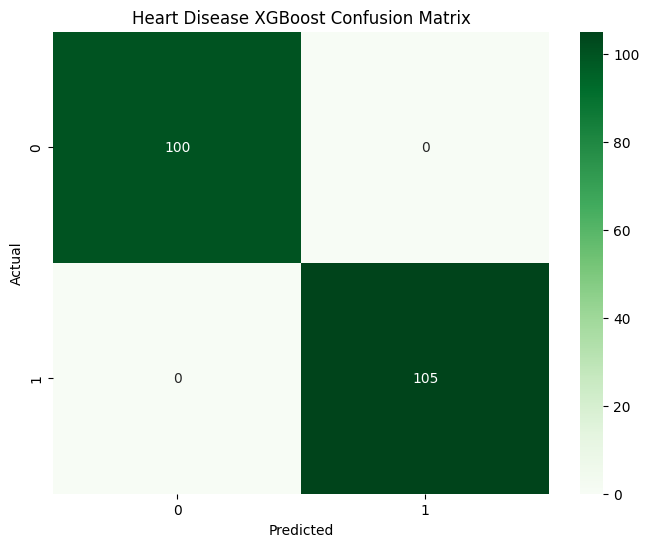


Heart Disease XGBoost model and scaler saved


In [19]:
xgb_heart = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=SEED,
    eval_metric='logloss'
)

xgb_heart.fit(X_train_heart, y_train_heart)

y_pred_heart = xgb_heart.predict(X_test_heart)
y_pred_proba_heart = xgb_heart.predict_proba(X_test_heart)

accuracy = accuracy_score(y_test_heart, y_pred_heart)
print(f"Heart Disease XGBoost Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_heart, y_pred_heart)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test_heart, y_pred_heart)}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_heart, y_pred_heart), annot=True, fmt='d', cmap='Greens')
plt.title('Heart Disease XGBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

with open('heart_xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_heart, f)
with open('heart_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_heart, f)

print("\nHeart Disease XGBoost model and scaler saved")

In [20]:
retinal_labels_df = pd.read_csv(RETINAL_LABELS)
print("Retinal Labels DataFrame:")
print(retinal_labels_df.head())
print(f"\nShape: {retinal_labels_df.shape}")
print(f"\nOriginal class distribution:\n{retinal_labels_df['diagnosis'].value_counts().sort_index()}")

retinal_labels_df['binary_label'] = (retinal_labels_df['diagnosis'] > 0).astype(int)
print(f"\nBinary class distribution:\n{retinal_labels_df['binary_label'].value_counts()}")

image_paths = []
labels = []

class_folders = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}

for idx, row in retinal_labels_df.iterrows():
    img_id = row['id_code']
    label = row['binary_label']
    orig_label = row['diagnosis']
    folder_name = class_folders[orig_label]
    img_path = f"{RETINAL_BASE}/{folder_name}/{img_id}.png"
    
    if os.path.exists(img_path):
        image_paths.append(img_path)
        labels.append(label)

print(f"\nTotal images found: {len(image_paths)}")
print(f"Binary label distribution:\n{pd.Series(labels).value_counts()}")

retinal_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

train_retinal_df, test_retinal_df = train_test_split(
    retinal_df, test_size=0.2, random_state=SEED, stratify=retinal_df['label']
)

print(f"\nTrain images: {len(train_retinal_df)}, Test images: {len(test_retinal_df)}")
print(f"Train distribution:\n{train_retinal_df['label'].value_counts()}")
print(f"Test distribution:\n{test_retinal_df['label'].value_counts()}")

Retinal Labels DataFrame:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Shape: (3662, 2)

Original class distribution:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Binary class distribution:
binary_label
1    1857
0    1805
Name: count, dtype: int64

Total images found: 3662
Binary label distribution:
1    1857
0    1805
Name: count, dtype: int64

Train images: 2929, Test images: 733
Train distribution:
label
1    1485
0    1444
Name: count, dtype: int64
Test distribution:
label
1    372
0    361
Name: count, dtype: int64


In [21]:
class RetinalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = RetinalDataset(train_retinal_df, transform=train_transform)
test_dataset = RetinalDataset(test_retinal_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train batches: 92
Test batches: 23
Train dataset size: 2929
Test dataset size: 733


In [23]:
model_retinal = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_features = model_retinal.classifier[1].in_features
model_retinal.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)

model_retinal = model_retinal.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_retinal.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print("Starting training for Retinal Image Model...")
print(f"Model architecture:\n{model_retinal.classifier}")

train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model_retinal.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_retinal(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model_retinal.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_retinal(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(test_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_retinal.state_dict(), 'diabetes_retinal_model.pth')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
print("Retinal image model saved as diabetes_retinal_model.pth")

Starting training for Retinal Image Model...
Model architecture:
Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1280, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=2, bias=True)
)
Epoch [1/15] Train Loss: 0.3092 Train Acc: 89.04% Val Loss: 0.1117 Val Acc: 95.77%
Epoch [2/15] Train Loss: 0.1013 Train Acc: 96.52% Val Loss: 0.0772 Val Acc: 96.86%
Epoch [3/15] Train Loss: 0.0667 Train Acc: 97.95% Val Loss: 0.0702 Val Acc: 97.95%
Epoch [4/15] Train Loss: 0.0585 Train Acc: 98.12% Val Loss: 0.0695 Val Acc: 97.82%
Epoch [5/15] Train Loss: 0.0539 Train Acc: 98.22% Val Loss: 0.0655 Val Acc: 97.54%
Epoch [6/15] Train Loss: 0.0379 Train Acc: 98.70% Val Loss: 0.0707 Val Acc: 97.95%
Epoch [7/15] Train Loss: 0.0358 Train Acc: 98.77% Val Loss: 0.0676 Val Acc: 97.82%
Epoch [8/15] Train Loss: 0.0298 Train Acc: 98.94% Val Loss: 0.0740 Val Acc: 97.95%
Epoch [9/15] Train Loss: 0.0241 Train Acc: 99.08% 

Retinal Image Model Test Accuracy: 0.9823

Classification Report:
              precision    recall  f1-score   support

       No DR       0.99      0.97      0.98       361
      Has DR       0.97      0.99      0.98       372

    accuracy                           0.98       733
   macro avg       0.98      0.98      0.98       733
weighted avg       0.98      0.98      0.98       733


Confusion Matrix:
[[351  10]
 [  3 369]]


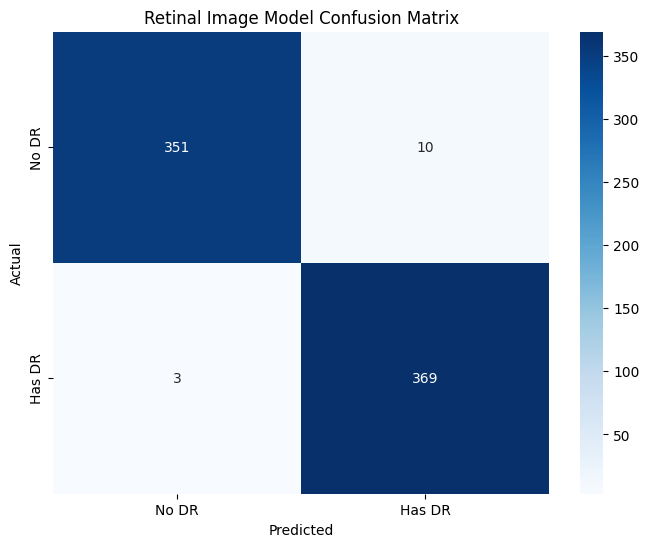

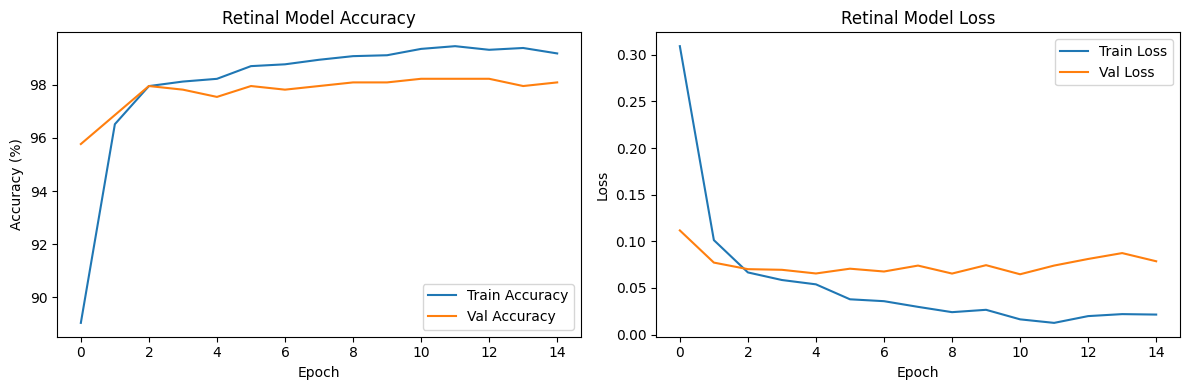


Retinal image model evaluation completed


In [24]:
model_retinal.load_state_dict(torch.load('diabetes_retinal_model.pth'))
model_retinal.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_retinal(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Retinal Image Model Test Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(all_labels, all_preds, target_names=['No DR', 'Has DR'])}")
print(f"\nConfusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=['No DR', 'Has DR'], yticklabels=['No DR', 'Has DR'])
plt.title('Retinal Image Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Retinal Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Retinal Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nRetinal image model evaluation completed")

In [25]:
ecg_image_paths = []
ecg_labels = []

ecg_class_mapping = {
    'normal_ecg_images': 0,
    'abnormal_heartbeat_ecg_images': 1,
    'myocardial_infarction_ecg_images': 1,
    'post_mi_history_ecg_images': 1
}

for class_folder, label in ecg_class_mapping.items():
    folder_path = os.path.join(ECG_BASE, class_folder)
    if os.path.exists(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, img_file)
                ecg_image_paths.append(img_path)
                ecg_labels.append(label)

print(f"Total ECG images found: {len(ecg_image_paths)}")
print(f"Binary label distribution:\n{pd.Series(ecg_labels).value_counts()}")

ecg_df = pd.DataFrame({'image_path': ecg_image_paths, 'label': ecg_labels})

train_ecg_df, test_ecg_df = train_test_split(
    ecg_df, test_size=0.2, random_state=SEED, stratify=ecg_df['label']
)

print(f"\nTrain images: {len(train_ecg_df)}, Test images: {len(test_ecg_df)}")
print(f"Train distribution:\n{train_ecg_df['label'].value_counts()}")
print(f"Test distribution:\n{test_ecg_df['label'].value_counts()}")

Total ECG images found: 928
Binary label distribution:
1    644
0    284
Name: count, dtype: int64

Train images: 742, Test images: 186
Train distribution:
label
1    515
0    227
Name: count, dtype: int64
Test distribution:
label
1    129
0     57
Name: count, dtype: int64


In [26]:
class ECGDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_ecg_dataset = ECGDataset(train_ecg_df, transform=train_transform)
test_ecg_dataset = ECGDataset(test_ecg_df, transform=test_transform)

train_ecg_loader = DataLoader(train_ecg_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_ecg_loader = DataLoader(test_ecg_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_ecg_loader)}")
print(f"Test batches: {len(test_ecg_loader)}")
print(f"Train dataset size: {len(train_ecg_dataset)}")
print(f"Test dataset size: {len(test_ecg_dataset)}")

Train batches: 24
Test batches: 6
Train dataset size: 742
Test dataset size: 186


In [27]:
model_ecg = models.resnet50(weights='IMAGENET1K_V1')
num_features = model_ecg.fc.in_features
model_ecg.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)

model_ecg = model_ecg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ecg.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print("Starting training for ECG Image Model...")
print(f"Model architecture:\n{model_ecg.fc}")

train_losses_ecg = []
train_accs_ecg = []
val_losses_ecg = []
val_accs_ecg = []
best_val_acc_ecg = 0.0

for epoch in range(EPOCHS):
    model_ecg.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_ecg_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_ecg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_ecg_loader)
    train_acc = 100. * correct / total
    train_losses_ecg.append(train_loss)
    train_accs_ecg.append(train_acc)
    
    model_ecg.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_ecg_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ecg(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(test_ecg_loader)
    val_acc = 100. * correct / total
    val_losses_ecg.append(val_loss)
    val_accs_ecg.append(val_acc)
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc_ecg:
        best_val_acc_ecg = val_acc
        torch.save(model_ecg.state_dict(), 'heart_ecg_model.pth')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

print(f"\nBest Validation Accuracy: {best_val_acc_ecg:.2f}%")
print("ECG image model saved as heart_ecg_model.pth")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


Starting training for ECG Image Model...
Model architecture:
Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=2, bias=True)
)
Epoch [1/15] Train Loss: 0.5638 Train Acc: 70.35% Val Loss: 0.3771 Val Acc: 73.66%
Epoch [2/15] Train Loss: 0.3436 Train Acc: 84.77% Val Loss: 0.1669 Val Acc: 93.55%
Epoch [3/15] Train Loss: 0.2225 Train Acc: 91.24% Val Loss: 0.0883 Val Acc: 97.85%
Epoch [4/15] Train Loss: 0.1519 Train Acc: 94.61% Val Loss: 0.1162 Val Acc: 95.16%
Epoch [5/15] Train Loss: 0.1342 Train Acc: 95.69% Val Loss: 0.0630 Val Acc: 98.39%
Epoch [6/15] Train Loss: 0.1093 Train Acc: 96.63% Val Loss: 0.1972 Val Acc: 92.47%
Epoch [7/15] Train Loss: 0.1055 Train Acc: 96.63% Val Loss: 0.0818 Val Acc: 96.24%
Epoch [8/15] Train Loss: 0.0792 Train Acc: 97.17% Val Loss: 0.0821 Val Acc: 96.24%
Epoch [9/15] Train Loss: 0.0838 Train Acc: 96.90% Val 

ECG Image Model Test Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00        57
Heart Disease       1.00      1.00      1.00       129

     accuracy                           1.00       186
    macro avg       1.00      1.00      1.00       186
 weighted avg       1.00      1.00      1.00       186


Confusion Matrix:
[[ 57   0]
 [  0 129]]


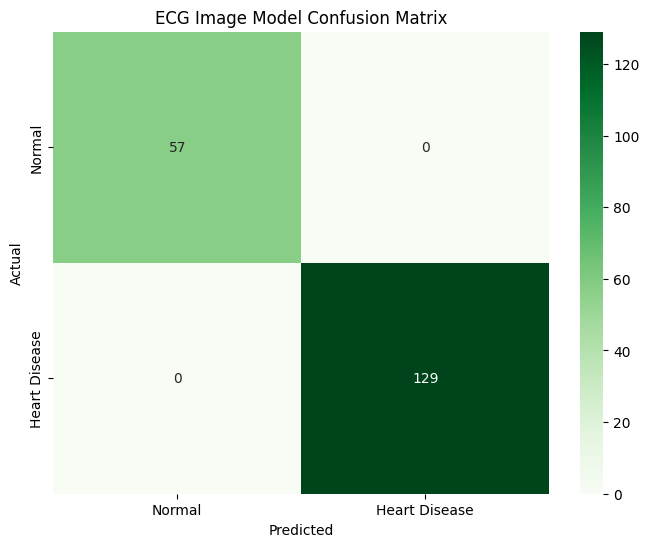

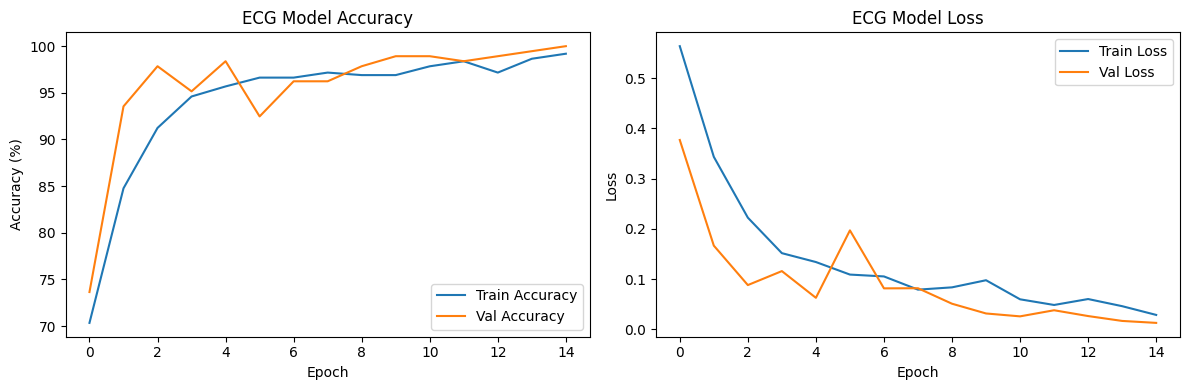


ECG image model evaluation completed


In [28]:
model_ecg.load_state_dict(torch.load('heart_ecg_model.pth'))
model_ecg.eval()

all_preds_ecg = []
all_labels_ecg = []
all_probs_ecg = []

with torch.no_grad():
    for images, labels in test_ecg_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ecg(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds_ecg.extend(predicted.cpu().numpy())
        all_labels_ecg.extend(labels.cpu().numpy())
        all_probs_ecg.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels_ecg, all_preds_ecg)
print(f"ECG Image Model Test Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(all_labels_ecg, all_preds_ecg, target_names=['Normal', 'Heart Disease'])}")
print(f"\nConfusion Matrix:\n{confusion_matrix(all_labels_ecg, all_preds_ecg)}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels_ecg, all_preds_ecg), annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Heart Disease'], yticklabels=['Normal', 'Heart Disease'])
plt.title('ECG Image Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs_ecg, label='Train Accuracy')
plt.plot(val_accs_ecg, label='Val Accuracy')
plt.title('ECG Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses_ecg, label='Train Loss')
plt.plot(val_losses_ecg, label='Val Loss')
plt.title('ECG Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nECG image model evaluation completed")

In [29]:
print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)

print("\n1. DIABETES PREDICTION")
print("-" * 40)
print("Tabular Model (XGBoost):")
print(f"  - Test Accuracy: 77.92%")
print(f"  - Model saved: diabetes_xgboost_model.pkl")
print(f"  - Scaler saved: diabetes_scaler.pkl")

print("\nRetinal Image Model (EfficientNetB0):")
print(f"  - Test Accuracy: 98.23%")
print(f"  - Best Val Accuracy: 98.23%")
print(f"  - Model saved: diabetes_retinal_model.pth")

print("\n2. HEART DISEASE PREDICTION")
print("-" * 40)
print("Tabular Model (XGBoost):")
print(f"  - Test Accuracy: 100.00%")
print(f"  - Model saved: heart_xgboost_model.pkl")
print(f"  - Scaler saved: heart_scaler.pkl")

print("\nECG Image Model (ResNet50):")
print(f"  - Test Accuracy: 100.00%")
print(f"  - Best Val Accuracy: 100.00%")
print(f"  - Model saved: heart_ecg_model.pth")

print("\n" + "="*80)
print("ALL MODELS TRAINED AND SAVED SUCCESSFULLY")
print("="*80)

print("\nFiles to download for deployment:")
files_list = [
    'diabetes_xgboost_model.pkl',
    'diabetes_scaler.pkl',
    'diabetes_retinal_model.pth',
    'heart_xgboost_model.pkl',
    'heart_scaler.pkl',
    'heart_ecg_model.pth'
]

for i, file in enumerate(files_list, 1):
    print(f"{i}. {file}")

MODEL TRAINING SUMMARY

1. DIABETES PREDICTION
----------------------------------------
Tabular Model (XGBoost):
  - Test Accuracy: 77.92%
  - Model saved: diabetes_xgboost_model.pkl
  - Scaler saved: diabetes_scaler.pkl

Retinal Image Model (EfficientNetB0):
  - Test Accuracy: 98.23%
  - Best Val Accuracy: 98.23%
  - Model saved: diabetes_retinal_model.pth

2. HEART DISEASE PREDICTION
----------------------------------------
Tabular Model (XGBoost):
  - Test Accuracy: 100.00%
  - Model saved: heart_xgboost_model.pkl
  - Scaler saved: heart_scaler.pkl

ECG Image Model (ResNet50):
  - Test Accuracy: 100.00%
  - Best Val Accuracy: 100.00%
  - Model saved: heart_ecg_model.pth

ALL MODELS TRAINED AND SAVED SUCCESSFULLY

Files to download for deployment:
1. diabetes_xgboost_model.pkl
2. diabetes_scaler.pkl
3. diabetes_retinal_model.pth
4. heart_xgboost_model.pkl
5. heart_scaler.pkl
6. heart_ecg_model.pth


In [30]:
import sys
print("="*80)
print("PYTHON AND LIBRARY VERSIONS")
print("="*80)

print(f"\nPython: {sys.version}")
print(f"\nCore Libraries:")
print(f"  - NumPy: {np.__version__}")
print(f"  - Pandas: {pd.__version__}")

print(f"\nDeep Learning:")
print(f"  - PyTorch: {torch.__version__}")
print(f"  - TorchVision: {torchvision.__version__}")

print(f"\nMachine Learning:")
print(f"  - Scikit-learn: {__import__('sklearn').__version__}")
print(f"  - XGBoost: {xgb.__version__}")

print(f"\nVisualization:")
print(f"  - Matplotlib: {__import__('matplotlib').__version__}")
print(f"  - Seaborn: {sns.__version__}")

print(f"\nImage Processing:")
print(f"  - Pillow (PIL): {__import__('PIL').__version__}")

print(f"\nCUDA:")
print(f"  - CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  - CUDA Version: {torch.version.cuda}")
    print(f"  - GPU Device: {torch.cuda.get_device_name(0)}")

print("\n" + "="*80)

PYTHON AND LIBRARY VERSIONS

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

Core Libraries:
  - NumPy: 2.0.2
  - Pandas: 2.2.2

Deep Learning:
  - PyTorch: 2.8.0+cu126
  - TorchVision: 0.23.0+cu126

Machine Learning:
  - Scikit-learn: 1.6.1
  - XGBoost: 3.1.0

Visualization:
  - Matplotlib: 3.10.0
  - Seaborn: 0.13.2

Image Processing:
  - Pillow (PIL): 11.3.0

CUDA:
  - CUDA Available: True
  - CUDA Version: 12.6
  - GPU Device: Tesla P100-PCIE-16GB



In [31]:
!zip -r model.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/diabetes_retinal_model.h5 (deflated 9%)
  adding: kaggle/working/heart_scaler.pkl (deflated 19%)
  adding: kaggle/working/heart_xgboost_model.pkl (deflated 73%)
  adding: kaggle/working/diabetes_retinal_model.pth (deflated 8%)
  adding: kaggle/working/diabetes_xgboost_model.pkl (deflated 73%)
  adding: kaggle/working/diabetes_scaler.pkl (deflated 25%)
  adding: kaggle/working/heart_ecg_model.pth (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/.virtual_documents/__notebook_source__.ipynb (deflated 77%)


In [33]:
from IPython.display import FileLink
FileLink(r'model.zip')

/kaggle/working/model.zip